In [3]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

from tensorflow.keras import Input, layers, models
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [4]:
patient_data = pd.DataFrame()

In [5]:
current_dir = os.getcwd()

In [ ]:
# Load data
for file in glob.glob(os.path.join(current_dir, "*.csv")):
    patient_data = patient_data.append(pd.read_csv(file), ignore_index=True)

In [ ]:
patient_data[patient_data.duplicated()]

In [ ]:
patient_data.shape

In [ ]:
data_filename = os.path.join(current_dir, "patient_data.csv")
patient_data.to_csv(data_filename, index=False)

In [ ]:
os.system(f"chmod 774 {data_filename}")
os.system("rm dp-cn*")

In [6]:
patient_data = pd.read_csv("patient_data.csv")

In [7]:
# PAY ATTENTION TO THIS!!!!
patient_data.PaO2 = patient_data.PaO2 * 7.50062
patient_data.PaCO2 = patient_data.PaCO2 * 7.50062

In [8]:
# Standardise the Features
# scaler = MinMaxScaler(feature_range=(0, 1)) ## NOPE: not for normal dist.
# scaler = Normalizer() ## NOPE
# scaler = StandardScaler()
scaler = QuantileTransformer(n_quantiles=10000, output_distribution="normal")

patient_data_norm = pd.DataFrame(
    scaler.fit_transform(patient_data), columns=patient_data.columns
)

In [9]:
# reduced_scaler = StandardScaler()
reduced_scaler = QuantileTransformer(n_quantiles=10000, output_distribution="normal")

In [10]:
# # For StandardScaler inheritance
# reduced_scaler.scale_ = scaler.scale_[-4:]
# reduced_scaler.mean_ = scaler.mean_[-4:]
# reduced_scaler.var_ = scaler.var_[-4:]
# reduced_scaler.n_features_in_ = 4
# reduced_scaler.n_samples_seen_ = patient_data.shape[0]

# # For QuantileTransformer inheritance
reduced_scaler.fit(patient_data[["PaO2", "PaCO2", "HCO3", "pH"]])
reduced_scaler.quantiles_ = scaler.quantiles_[:, -4:]

In [11]:
# Split data into train and test sets
train_data, test_data = train_test_split(
    patient_data_norm,
    test_size=0.1,
    shuffle=True,
)

In [12]:
# Create validation set
train_data, val_data = train_test_split(
    train_data,
    test_size=test_data.shape[0],
    shuffle=True,
)

In [13]:
# Split all datasets into input and expected outputs
x_train, y_train = train_data.iloc[:, :-4].values, train_data.iloc[:, -4:].values
x_test, y_test = test_data.iloc[:, :-4].values, test_data.iloc[:, -4:].values
x_val, y_val = val_data.iloc[:, :-4].values, val_data.iloc[:, -4:].values

## Initialise Multi-Layer Perceptron (Functional API)

In [38]:
inputs = Input(shape=(x_train.shape[1],), name="Input_Layer")

layer = layers.Dense(32, activation="relu", name="Dense_Layer_1")(inputs)
layer = layers.Dropout(0.5, name="Dropout_Layer")(layer)
layer = layers.Dense(
    64,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Dense_Layer_2",
)(layer)
layer = layers.Dropout(0.5, name="Dropout_Layer2")(layer)
layer = layers.Dense(
    64,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Dense_Layer_3",
)(layer)
layer = layers.Dropout(0.5, name="Dropout_Layer3")(layer)
layer = layers.Dense(
    64,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Dense_Layer_4",
)(layer)

outputs = layers.Dense(4, name="Output_Layer")(layer)

In [39]:
MLP_model = models.Model(inputs=inputs, outputs=outputs, name="MLP")

In [40]:
MLP_model.compile(
    loss="mae", optimizer=Adam(learning_rate=1e-5), metrics=["mse", "mae"]
)

In [41]:
MLP_model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 19)]              0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 32)                640       
_________________________________________________________________
Dropout_Layer (Dropout)      (None, 32)                0         
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 64)                2112      
_________________________________________________________________
Dropout_Layer2 (Dropout)     (None, 64)                0         
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 64)                4160      
_________________________________________________________________
Dropout_Layer3 (Dropout)     (None, 64)                0       

In [42]:
history = MLP_model.fit(
    x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=128
)

Epoch 1/50
6250/6250 [==============================] - 11s 2ms/step - loss: 2.3389 - mse: 1.1673 - mae: 0.8561 - val_loss: 1.6289 - val_mse: 0.8605 - val_mae: 0.7327
Epoch 2/50
6250/6250 [==============================] - 10s 2ms/step - loss: 1.4891 - mse: 0.8764 - mae: 0.7364 - val_loss: 0.9712 - val_mse: 0.5386 - val_mae: 0.5539
Epoch 3/50
6250/6250 [==============================] - 10s 2ms/step - loss: 0.9859 - mse: 0.6860 - mae: 0.6382 - val_loss: 0.6759 - val_mse: 0.4288 - val_mae: 0.4833
Epoch 4/50
6250/6250 [==============================] - 10s 2ms/step - loss: 0.7410 - mse: 0.5737 - mae: 0.5770 - val_loss: 0.5509 - val_mse: 0.3751 - val_mae: 0.4480
Epoch 5/50
6250/6250 [==============================] - 10s 2ms/step - loss: 0.6239 - mse: 0.4971 - mae: 0.5325 - val_loss: 0.4935 - val_mse: 0.3458 - val_mae: 0.4287
Epoch 6/50
6250/6250 [==============================] - 10s 2ms/step - loss: 0.5620 - mse: 0.4475 - mae: 0.5029 - val_loss: 0.4615 - val_mse: 0.3272 - val_mae: 0.416

In [43]:
history4=history

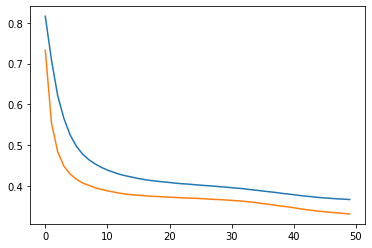

In [44]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])

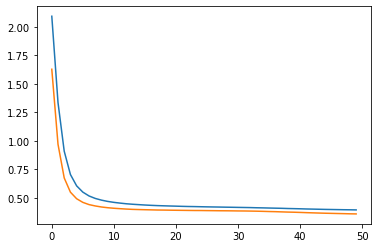

In [45]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
MLP_model.evaluate(x_test, y_test)

In [ ]:
reduced_scaler.inverse_transform(y_test)

In [ ]:
reduced_scaler.inverse_transform(MLP_model.predict(x_test))

## Initialise Convolutional Neural Network

#### Try more layers (even though fewer layers seems to have had a positive effect on the output.
#### Also, check output accuracy per feature

In [14]:
inputs = Input(shape=(x_train.shape[1], 1), name="Input_Layer")

layer = layers.Conv1D(64, 9, activation="relu", name="Conv_Layer_1")(inputs)
# layer = layers.MaxPool1D(2, name="Pooling_Layer")(layer)
layer = layers.Conv1D(
    128,
    5,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Conv_Layer_2",
)(layer)
layer = layers.Dropout(0.5, name="Dropout_Layer")(layer)
layer = layers.Conv1D(
    64,
    5,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Conv_Layer_3",
)(layer)
layer = layers.Dropout(0.5, name="Dropout_Layer2")(layer)
layer = layers.Conv1D(
    64,
    3,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Conv_Layer_4",
)(layer)
layer = layers.Flatten(name="Flatten_Layer")(layer)
# layer = layers.Dense(10, name="Fully_Connected_Layer")(layer)

outputs = layers.Dense(4, name="Output_Layer")(layer)

In [15]:
CNN_model = models.Model(inputs=inputs, outputs=outputs, name="CNN")

In [16]:
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 19, 1)]           0         
_________________________________________________________________
Conv_Layer_1 (Conv1D)        (None, 11, 64)            640       
_________________________________________________________________
Conv_Layer_2 (Conv1D)        (None, 7, 128)            41088     
_________________________________________________________________
Dropout_Layer (Dropout)      (None, 7, 128)            0         
_________________________________________________________________
Conv_Layer_3 (Conv1D)        (None, 3, 64)             41024     
_________________________________________________________________
Dropout_Layer2 (Dropout)     (None, 3, 64)             0         
_________________________________________________________________
Conv_Layer_4 (Conv1D)        (None, 1, 64)             12352   

In [17]:
CNN_model.compile(
    loss="mae", optimizer=Adam(learning_rate=1e-4), metrics=["mse", "mae"]
)

In [18]:
history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
)

Epoch 1/50
6250/6250 [==============================] - 23s 3ms/step - loss: 0.9552 - mse: 0.3833 - mae: 0.4461 - val_loss: 0.3185 - val_mse: 0.1475 - val_mae: 0.2608
Epoch 2/50
6250/6250 [==============================] - 18s 3ms/step - loss: 0.3544 - mse: 0.1754 - mae: 0.2968 - val_loss: 0.2729 - val_mse: 0.1114 - val_mae: 0.2164
Epoch 3/50
6250/6250 [==============================] - 17s 3ms/step - loss: 0.3201 - mse: 0.1458 - mae: 0.2643 - val_loss: 0.2510 - val_mse: 0.0973 - val_mae: 0.1975
Epoch 4/50
6250/6250 [==============================] - 17s 3ms/step - loss: 0.3027 - mse: 0.1327 - mae: 0.2499 - val_loss: 0.2396 - val_mse: 0.0904 - val_mae: 0.1894
Epoch 5/50
6250/6250 [==============================] - 17s 3ms/step - loss: 0.2922 - mse: 0.1260 - mae: 0.2425 - val_loss: 0.2308 - val_mse: 0.0852 - val_mae: 0.1829
Epoch 6/50
6250/6250 [==============================] - 17s 3ms/step - loss: 0.2829 - mse: 0.1197 - mae: 0.2353 - val_loss: 0.2180 - val_mse: 0.0772 - val_mae: 0.171

In [19]:
history2 = history

In [20]:
CNN_model.evaluate(x_test, y_test)

3125/3125 [==============================] - 5s 2ms/step - loss: 0.1660 - mse: 0.0499 - mae: 0.1353


[0.1660342961549759, 0.04986920580267906, 0.1353159248828888]

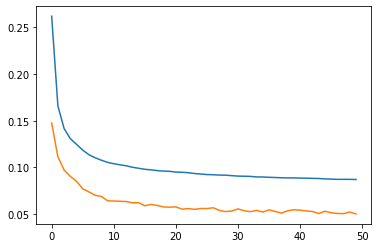

In [21]:
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])

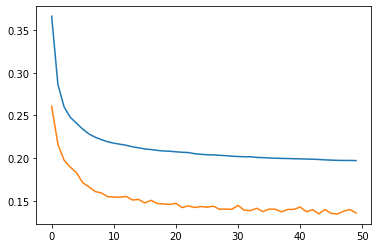

In [22]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
# plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])

In [ ]:
reduced_scaler.inverse_transform(CNN_model.predict(x_test))

In [ ]:
reduced_scaler.inverse_transform(y_test)

## Configurations that Work

### Go for this one and try to improve

In [154]:
dropout_rate = 0.5
learning_rate = 0.000040
batch_size = 128
loss_function = "mse"

In [155]:
inputs = Input(shape=(x_train.shape[1], 1), name="Input_Layer")

layer = layers.Conv1D(64, 9, activation="relu", name="Conv_Layer_1")(inputs)
layer = layers.Conv1D(
    128,
    5,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Conv_Layer_2",
)(layer)
layer = layers.Dropout(dropout_rate, name="Dropout_Layer_1")(layer)
layer = layers.Conv1D(
    128,
    5,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Conv_Layer_3",
)(layer)
layer = layers.Dropout(dropout_rate, name="Dropout_Layer_2")(layer)
layer = layers.Conv1D(
    128,
    3,
    activation="relu",
    kernel_initializer="glorot_uniform",
    kernel_regularizer="l2",
    name="Conv_Layer_4",
)(layer)
layer = layers.Flatten(name="Flatten_Layer")(layer)

layer = layers.Dense(20, activation="relu", name="Fully_Connected_Layer")(layer)

outputs = layers.Dense(4, name="Output_Layer")(layer)

In [156]:
CNN_model = models.Model(inputs=inputs, outputs=outputs, name="CNN")

In [157]:
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 19, 1)]           0         
_________________________________________________________________
Conv_Layer_1 (Conv1D)        (None, 11, 64)            640       
_________________________________________________________________
Conv_Layer_2 (Conv1D)        (None, 7, 128)            41088     
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 7, 128)            0         
_________________________________________________________________
Conv_Layer_3 (Conv1D)        (None, 3, 128)            82048     
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 3, 128)            0         
_________________________________________________________________
Conv_Layer_4 (Conv1D)        (None, 1, 128)            49280   

In [158]:
CNN_model.compile(
    loss=loss_function,
    optimizer=Adam(learning_rate=learning_rate),
    metrics=["mse", "mae"],
)

In [ ]:
def schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch % 10 == 0:
        return lr * tf.math.exp(0.1)
    else:
        return lr

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(schedule)

In [159]:
history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=batch_size,
#     callbacks=[callback]
)

Epoch 1/100
6250/6250 [==============================] - 19s 3ms/step - loss: 1.6768 - mse: 0.4515 - mae: 0.4926 - val_loss: 0.2181 - val_mse: 0.1401 - val_mae: 0.2655
Epoch 2/100
6250/6250 [==============================] - 17s 3ms/step - loss: 0.2338 - mse: 0.1660 - mae: 0.2996 - val_loss: 0.1593 - val_mse: 0.1046 - val_mae: 0.2217
Epoch 3/100
6250/6250 [==============================] - 17s 3ms/step - loss: 0.1871 - mse: 0.1342 - mae: 0.2659 - val_loss: 0.1325 - val_mse: 0.0835 - val_mae: 0.1926
Epoch 4/100
6250/6250 [==============================] - 17s 3ms/step - loss: 0.1633 - mse: 0.1152 - mae: 0.2433 - val_loss: 0.1163 - val_mse: 0.0703 - val_mae: 0.1720
Epoch 5/100
6250/6250 [==============================] - 18s 3ms/step - loss: 0.1475 - mse: 0.1025 - mae: 0.2277 - val_loss: 0.1051 - val_mse: 0.0625 - val_mae: 0.1608
Epoch 6/100
6250/6250 [==============================] - 17s 3ms/step - loss: 0.1372 - mse: 0.0954 - mae: 0.2189 - val_loss: 0.0986 - val_mse: 0.0589 - val_mae:

In [160]:
history1 = history

In [161]:
CNN_model.evaluate(x_test, y_test)

3125/3125 [==============================] - 6s 2ms/step - loss: 0.0617 - mse: 0.0450 - mae: 0.1420


[0.061700839549303055, 0.04500385373830795, 0.14196065068244934]

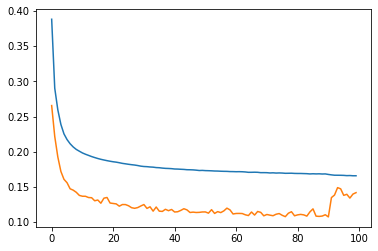

In [162]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])

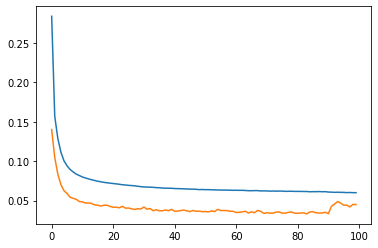

In [163]:
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
# plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])

In [164]:
tf.saved_model.save(CNN_model, "./saved_model/fifo/")

INFO:tensorflow:Assets written to: ./saved_model/fifo/assets


In [114]:
from sklearn.metrics import r2_score, mean_squared_error

In [165]:
y_pred = CNN_model.predict(x_test)

In [116]:
pbt_scores = [
    r2_score(y_test[:, 0], y_pred[:, 0]),
    r2_score(y_test[:, 1], y_pred[:, 1]),
    r2_score(y_test[:, 2], y_pred[:, 2]),
    r2_score(y_test[:, 3], y_pred[:, 3]),
]

In [135]:
ahb_scores = [
    r2_score(y_test[:, 0], y_pred[:, 0]),
    r2_score(y_test[:, 1], y_pred[:, 1]),
    r2_score(y_test[:, 2], y_pred[:, 2]),
    r2_score(y_test[:, 3], y_pred[:, 3]),
]

In [151]:
hpb_scores = [
    r2_score(y_test[:, 0], y_pred[:, 0]),
    r2_score(y_test[:, 1], y_pred[:, 1]),
    r2_score(y_test[:, 2], y_pred[:, 2]),
    r2_score(y_test[:, 3], y_pred[:, 3]),
]

In [166]:
fifo_scores = [
    r2_score(y_test[:, 0], y_pred[:, 0]),
    r2_score(y_test[:, 1], y_pred[:, 1]),
    r2_score(y_test[:, 2], y_pred[:, 2]),
    r2_score(y_test[:, 3], y_pred[:, 3]),
]

In [136]:
r2_score(y_test[:,0], y_pred[:,0])

0.9205907011550706

In [118]:
r2_score(y_test[:,1], y_pred[:,1])

0.9707016241421853

In [119]:
r2_score(y_test[:,2], y_pred[:,2])

0.9798950092355141

In [120]:
r2_score(y_test[:,3], y_pred[:,3])

0.977179126246676

In [30]:
np.mean(
    [
        mean_squared_error(y_test[:, 0], y_pred[:, 0]),
        mean_squared_error(y_test[:, 1], y_pred[:, 1]),
        mean_squared_error(y_test[:, 2], y_pred[:, 2]),
        mean_squared_error(y_test[:, 3], y_pred[:, 3]),
    ]
)

0.03613408217525364

In [ ]:
np.mean([y_test[:,0]-y_pred[:,0]])

In [31]:
pred_val = reduced_scaler.inverse_transform(y_pred)

In [32]:
true_val = reduced_scaler.inverse_transform(y_test)

In [33]:
np.mean(true_val-pred_val, axis=0)

array([ 0.62598822, -5.56577064, -0.15745621,  0.00617317])

In [34]:
pao2_true = true_val[:,0]
pao2_pred = pred_val[:,0]

In [35]:
pao2 = pd.DataFrame({"true":pao2_true, "pred": pao2_pred})

In [36]:
pao2 = pao2[(pao2["true"]>10) | (pao2["pred"]>10)].reset_index(drop=True)

In [37]:
pao2["diff"] = pao2["true"]-pao2["pred"]

In [38]:
pao2["diff"].mean()

0.7724705940783989

## Plot Results for paper

In [24]:
import pickle

In [50]:
with open('figures/ann_hist1', 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

In [25]:
with open('figures/cnn_hist2', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

In [167]:
with open('figures/final_hist1', 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

In [168]:
with open('figures/fifo_scores', 'wb') as file_pi:
    pickle.dump(fifo_scores, file_pi)